In [1]:
# Load required packages
import torch
from torch import nn
from matplotlib import pyplot as plt
plt.rcParams['text.usetex'] = False
import numpy as np

# register acceleration devices
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# Load Benchmark Data

out = np.load('training-val-test-data.npz')
th_data = out['th'] #th[0],th[1],th[2],th[3],...
u_data = out['u'] #u[0],u[1],u[2],u[3],...

from sklearn import model_selection
u_train, u_val, y_train, y_val= model_selection.train_test_split(u_data, th_data, shuffle=False, test_size=0.3,random_state=42)
# Standardization
u_mean, u_std = np.mean(u_train),np.std(u_train)
y_mean, y_std = np.mean(y_train),np.std(y_train)


### Data to train and validate on ###:
u_train = (u_train-u_mean)/u_std #normalize
y_train = (y_train-y_mean)/y_std

u_val = (u_val-u_mean)/u_std
y_val = (y_val-y_mean)/y_std


def make_OE_data(udata, ydata, nf=100):
    U = []
    Y = []
    for k in range(nf,len(udata)+1):
        U.append(udata[k-nf:k]) #a)
        Y.append(ydata[k-nf:k]) #a)
    return np.array(U), np.array(Y)

nfuture = 30
convert = lambda x: [torch.tensor(xi,dtype=torch.float64,device=device) for xi in x]
Utrain, Ytrain = convert(make_OE_data(u_train, y_train, nf=nfuture))
Uval,   Yval   = convert(make_OE_data(u_val,   y_val,   nf=len(u_val))) #uses the whole data set for OE

cuda


In [ ]:
# Code from EX3
class simple_RNN(nn.Module):
    def __init__(self, hidden_size):
        super(simple_RNN, self).__init__()
        self.hidden_size = hidden_size
        self.input_size = 1
        self.output_size = 1
        net = lambda n_in,n_out: nn.Sequential(nn.Linear(n_in,40), \
                                               nn.Tanh(), \
                                               nn.Linear(40,n_out)).double() #new short hand
        self.h2h = net(self.input_size + hidden_size, self.hidden_size) #b=)
        self.h2o = net(self.input_size + hidden_size, self.output_size) #b=)
                                                                        #[:,0] should be called after use of h2o

    def forward(self, inputs):
        #input.shape == (N_batch, N_time)
        hidden = torch.zeros(inputs.shape[0], self.hidden_size, dtype=torch.float64, device=device) #c)
        outputs = [] #c)
        for i in range(inputs.shape[1]): #c)
            u = inputs[:,i] #shape = (N_batch,) #c)
            combined = torch.cat((hidden, u[:,None]), dim=1) #c) #shape = (N_batch,hidden_size+1)
            outputs.append(self.h2o(combined)[:,0]) #c)
            hidden = self.h2h(combined) #c)
        return torch.stack(outputs,dim=1) #c)

n_burn = 10
batch_size = 64

model = simple_RNN(hidden_size=15) #d=)
#model = nn.DataParallel(model) # Wrap the model with DataParallel
model = model.to(device=device) # Move the model to the GPU
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4) #d=)


ids = np.arange(len(Utrain),dtype=int)
for epoch in range(50):
    np.random.shuffle(ids) #inspace shuffle of the ids of the training set to select a random subset
    for i in range(0,len(Utrain),batch_size):
        ids_now = ids[i:i+batch_size] #the ids of the current batch
        Uin = Utrain[ids_now] #d)
        Y_real = Ytrain[ids_now] #d)
        model.train()
        Y_predict = model.forward(inputs=Uin) #d)
        residual = Y_real - Y_predict #d)
        Loss = torch.mean(residual[:,n_burn:]**2) #d)

        optimizer.zero_grad()  #d)
        Loss.backward()  #d)
        optimizer.step()  #d)

    with torch.no_grad(): #monitor
        model.eval()
        Loss_val = torch.mean((model(inputs=Uval)[:,n_burn:] - Yval[:,n_burn:])**2)**0.5
        Loss_train = torch.mean((model(inputs=Utrain)[:,n_burn:] - Ytrain[:,n_burn:])**2)**0.5
        print(f'epoch={epoch}, Validation NRMS={Loss_val.item():.2%}, Train NRMS={Loss_train.item():.2%}')

KeyboardInterrupt: 

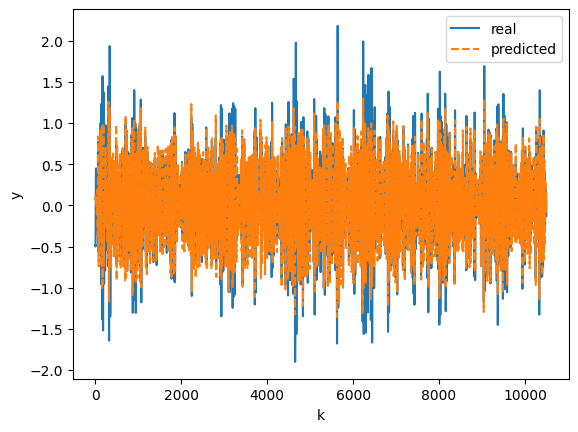

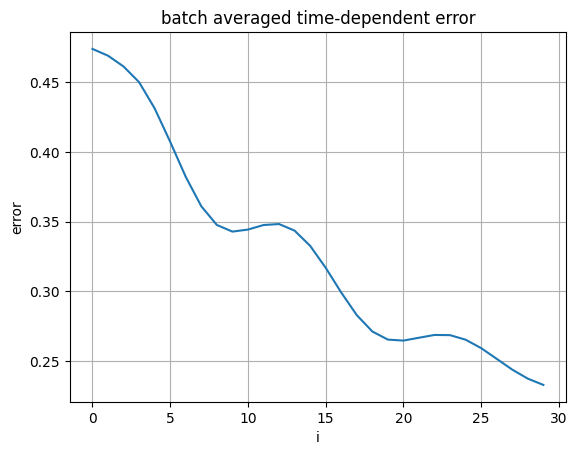

In [ ]:
with torch.no_grad():
    plt.plot((Yval[0]*y_std + y_mean).cpu())
    model.eval()
    plt.plot((model(inputs=Uval)[0] * y_std + y_mean).cpu(),'--')
    plt.xlabel('k')
    plt.ylabel('y')
    #plt.xlim(0,250)
    plt.legend(['real','predicted'])
    plt.show()
    model.eval()
    plt.plot(np.mean(((Ytrain-model(inputs=Utrain))*y_std).cpu().numpy()**2,axis=0)**0.5) #average over the error in batch
    plt.title('batch averaged time-dependent error')
    plt.ylabel('error')
    plt.xlabel('i')
    plt.grid()
    plt.show()

In [6]:
# LSTM from Exercise
'''
def make_OE_data(udata,ydata,nf=100):
    U = [] #[u[k-nf],...,u[k]]
    Y = [] #[y[k-nf],...,y[k]]
    for k in range(nf,len(udata)+1):
        U.append(udata[k-nf:k])
        Y.append(ydata[k-nf:k])
    return np.array(U),np.array(Y)

nfuture = 100
convert = lambda x: [torch.tensor(xi,dtype=torch.float64, device=device) for xi in x]
Utrain,Ytrain = convert(make_OE_data(u_train,y_train,nf=nfuture))
Uval,Yval = convert(make_OE_data(u_val,y_val,nf=len(u_val)))
'''
def make_OE_init_state_data(udata, ydata, nf=100, n_encode=20):
    U = []
    Y = []
    hist = []
    for k in range(nf+n_encode,len(udata)+1):
        hist.append(np.concatenate((udata[k-nf-n_encode:k-nf], ydata[k-nf-n_encode:k-nf]))) #f)
        U.append(udata[k-nf:k]) #f)
        Y.append(ydata[k-nf:k]) #f)
    return np.array(hist), np.array(U), np.array(Y)

nfuture = 35
n_encode = 10
convert = lambda x: [torch.tensor(xi, dtype=torch.float64,device=device) for xi in x]
histtrain, Utrain, Ytrain = convert(make_OE_init_state_data(u_train, y_train, nf=nfuture,            n_encode=n_encode))
histval,   Uval,   Yval   = convert(make_OE_init_state_data(u_val,   y_val,   nf=len(u_val)-n_encode, n_encode=n_encode))

class simple_encoder_RNN(nn.Module):
    def __init__(self, hidden_size, n_encoder=20):
        super(simple_encoder_RNN, self).__init__()
        self.hidden_size = hidden_size
        self.input_size = 1
        self.output_size = 1
        net = lambda n_in,n_out: nn.Sequential(nn.Linear(n_in,40),nn.Sigmoid(),nn.Linear(40,n_out)) #short hand for a 1 hidden layer NN
        self.rnn = nn.RNN(input_size=self.input_size,  hidden_size=hidden_size,  batch_first=True).double() #i)
        self.h2o = net(hidden_size + self.input_size, self.output_size).double() #i)
        self.hEncoder = net(n_encoder*2,hidden_size).double()

    def forward(self, inputs, hist):
        h0 = self.hEncoder(hist)
        hiddens, h_n = self.rnn(inputs[:,:,None],h0[None,:,:]) #i)
        combined = torch.cat((hiddens,inputs[:,:,None]),dim=2) #i)
        if False: #two ways to solve this #i)
            y_predict = [] #i)
            for i in range(combined.shape[1]):  #i)
                y_predict.append(self.h2o(combined[:,i,:])[:,0])  #i)
            y_predict = torch.stack(y_predict,dim=1)  #i)
        else: #this is faster but more complex #i)
            #reshape from (N_batch, N_time, N_hidden) to (N_batch*N_time, N_hidden) #i)
            h2o_input = combined.view(-1,self.hidden_size+self.input_size) #i)
            #apply and reshape from (N_batch*N_time,1) to (N_batch,N_time) #i)
            y_predict =  self.h2o(h2o_input).view(inputs.shape[0],inputs.shape[1])  #new #i)

        return y_predict

class simple_lstm(nn.Module):
    def __init__(self, hidden_size, n_encoder=20):
        super(simple_lstm, self).__init__()
        self.hidden_size = hidden_size
        self.input_size = 1
        self.output_size = 1
        net = lambda n_in,n_out: nn.Sequential(nn.Linear(n_in,40),nn.Sigmoid(),nn.Linear(40,n_out)) #short hand for a 1 hidden layer NN
        self.lstm = nn.LSTM(input_size=self.input_size,  hidden_size=hidden_size,  batch_first=True).double() #i)
        self.h2o = net(hidden_size + self.input_size, self.output_size).double() #i)
        self.hEncoder = net(n_encoder*2,hidden_size).double()
        self.cEncoder = net(n_encoder*2,hidden_size).double()

    def forward(self, inputs, hist):
        h0 = self.hEncoder(hist)
        c0 = self.cEncoder(hist)
        hiddens, (h_n, c_n) = self.lstm(inputs[:,:,None],(h0[None,:,:],c0[None,:,:])) #i)
        #hiddens, h_n = self.lstm(inputs[:,:,None]) #i)
        combined = torch.cat((hiddens,inputs[:,:,None]),dim=2) #i)
        if False: #two ways to solve this #i)
            y_predict = [] #i)
            for i in range(combined.shape[1]):  #i)
                y_predict.append(self.h2o(combined[:,i,:])[:,0])  #i)
            y_predict = torch.stack(y_predict,dim=1)  #i)
        else: #this is faster but more complex #i)
            #reshape from (N_batch, N_time, N_hidden) to (N_batch*N_time, N_hidden) #i)
            h2o_input = combined.view(-1,self.hidden_size+self.input_size) #i)
            #apply and reshape from (N_batch*N_time,1) to (N_batch,N_time) #i)
            y_predict =  self.h2o(h2o_input).view(inputs.shape[0],inputs.shape[1])  #new #i)

        return y_predict

n_burn = 0
#model = simple_lstm(hidden_size=20,n_encoder=n_encode)
model = simple_encoder_RNN(hidden_size=3,n_encoder=n_encode)
#model = nn.DataParallel(model) # Wrap the model with DataParallel
model = model.to(device=device) # Move the model to the GPU
optimizer = torch.optim.Adam(model.parameters(),lr=1e-3)
batch_size = 64
ids = np.arange(len(Utrain),dtype=int)
for epoch in range(500):
    model.train()
    for i in range(0,len(Utrain),batch_size):
        ids_now = ids[i:i+batch_size]
        Uin = Utrain[ids_now]
        histin = histtrain[ids_now]
        Yout = model.forward(inputs=Uin,hist=histin)
        Yin = Ytrain[ids_now]
        Loss = torch.mean((Yin[:,n_burn:] - Yout[:,n_burn:])**2)
        optimizer.zero_grad()
        Loss.backward()
        optimizer.step()

    with torch.no_grad():
        model.eval()
        Loss_val = torch.mean((model(inputs=Uval,hist=histval)[:,n_burn:] - Yval[:,n_burn:])**2)**0.5
        Loss_train = torch.mean((model(inputs=Utrain,hist=histtrain)[:,n_burn:] - Ytrain[:,n_burn:])**2)**0.5
        print(f'epoch={epoch}, Validation Loss={Loss_val.item():.2%}, Train Loss={Loss_train.item():.2%}, Validation Loss absolute={Loss_val.item() * y_std}')

epoch=0, Validation Loss=96.17%, Train Loss=86.46%, Validation Loss absolute=0.449923775050473
epoch=1, Validation Loss=91.71%, Train Loss=81.15%, Validation Loss absolute=0.42907454530686007
epoch=2, Validation Loss=90.77%, Train Loss=79.48%, Validation Loss absolute=0.4246618463234593
epoch=3, Validation Loss=90.42%, Train Loss=78.83%, Validation Loss absolute=0.42304030284171446
epoch=4, Validation Loss=90.21%, Train Loss=78.40%, Validation Loss absolute=0.4220729065179529
epoch=5, Validation Loss=90.05%, Train Loss=78.08%, Validation Loss absolute=0.42130580243953303
epoch=6, Validation Loss=89.92%, Train Loss=77.82%, Validation Loss absolute=0.42067801724311543
epoch=7, Validation Loss=89.80%, Train Loss=77.61%, Validation Loss absolute=0.4201478467453183
epoch=8, Validation Loss=89.71%, Train Loss=77.42%, Validation Loss absolute=0.41968898396554083
epoch=9, Validation Loss=89.63%, Train Loss=77.24%, Validation Loss absolute=0.41931982253218625
epoch=10, Validation Loss=89.57%, T

KeyboardInterrupt: 

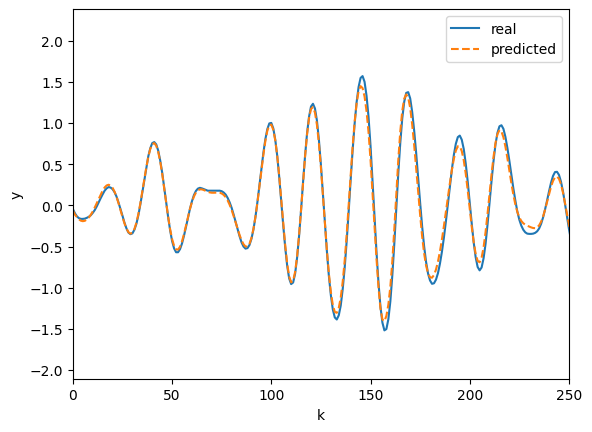

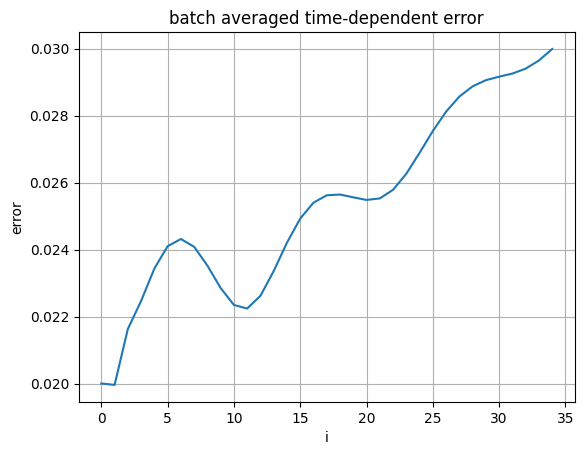

In [ ]:
with torch.no_grad():
    plt.plot((Yval[0]*y_std + y_mean).cpu())
    model.eval()
    plt.plot((model(inputs=Uval,hist=histval)[0] * y_std + y_mean).cpu(),'--')
    plt.xlabel('k')
    plt.ylabel('y')
    plt.xlim(0,250)
    plt.legend(['real','predicted'])
    plt.show()
    model.eval()
    plt.plot(y_std*np.mean(((Ytrain-model(inputs=Utrain,hist=histtrain))).cpu().numpy()**2,axis=0)**0.5) #average over the error in batch
    plt.title('batch averaged time-dependent error')
    plt.ylabel('error')
    plt.xlabel('i')
    plt.grid()
    plt.show()

train prediction errors:
RMS: tensor(0.0446, device='cuda:0', dtype=torch.float64) radians
RMS: tensor(2.5541, device='cuda:0', dtype=torch.float64) degrees
NRMS: tensor(9.5283, device='cuda:0', dtype=torch.float64) %


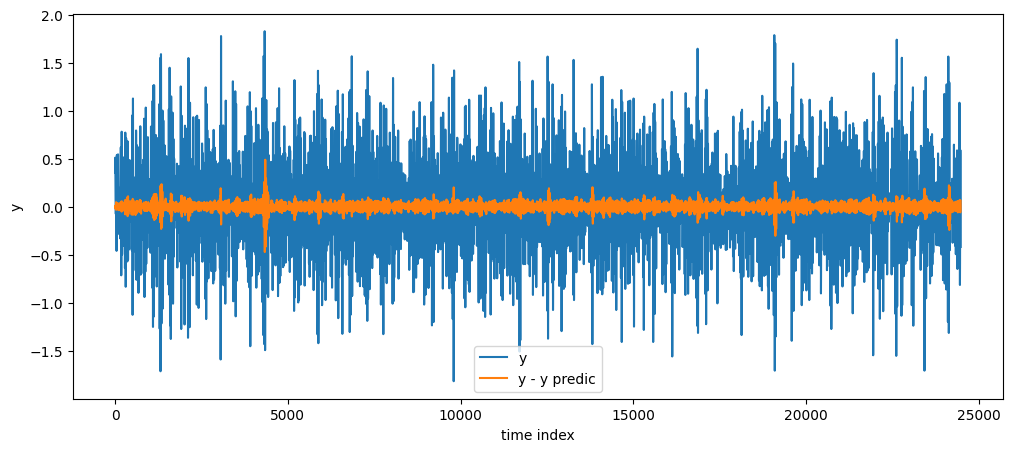

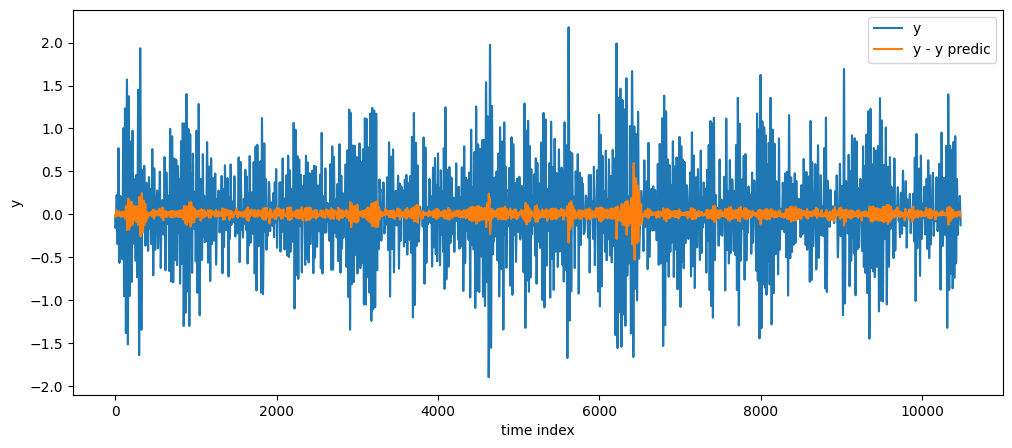

validation prediction errors:
RMS: tensor(0.0533, device='cuda:0', dtype=torch.float64) radians
RMS: tensor(3.0525, device='cuda:0', dtype=torch.float64) degrees
NRMS: tensor(10.5411, device='cuda:0', dtype=torch.float64) %


In [ ]:
#residual calculations and plotting
with torch.no_grad():
    model.eval()
    histtrain, Utrain, Ytrain = convert(make_OE_init_state_data(u_train, y_train, nf=nfuture,            n_encode=n_encode))
    histval,   Uval,   Yval   = convert(make_OE_init_state_data(u_val,   y_val,   nf=len(u_val)-n_encode, n_encode=n_encode))
    histTrainEval, UTrainEval, YTrainEval = convert(make_OE_init_state_data(u_train, y_train, nf=len(u_train)-n_encode, n_encode=n_encode))

    Ytrain = YTrainEval[0] * y_std + y_mean
    Ytrain_pred = model(inputs=UTrainEval,hist=histTrainEval)[0] * y_std + y_mean
    print('train prediction errors:')
    print('RMS:', torch.mean((Ytrain_pred-Ytrain)**2)**0.5,'radians')
    print('RMS:', torch.mean((Ytrain_pred-Ytrain)**2)**0.5/(2*np.pi)*360,'degrees')
    print('NRMS:', torch.mean((Ytrain_pred-Ytrain)**2)**0.5/y_std*100,'%')
    res = Ytrain_pred - Ytrain #b)
    plt.figure(figsize=(12,5)) #b)
    plt.plot(Ytrain.cpu()) #b)
    plt.plot(res.cpu()) #b)
    plt.xlabel('time index'); plt.ylabel('y'); plt.legend(['y','y - y predic'])#b)
    #plt.xlim(0,250)
    plt.show() #b)

    Yval = Yval[0] * y_std + y_mean
    Yval_pred = model(inputs=Uval,hist=histval)[0] * y_std + y_mean
    res = Yval_pred - Yval #b)
    plt.figure(figsize=(12,5)) #b)
    plt.plot(Yval.cpu()) #b)
    plt.plot(res.cpu()) #b)
    plt.xlabel('time index'); plt.ylabel('y'); plt.legend(['y','y - y predic'])#b)
    plt.show() #b)
    print('validation prediction errors:')
    print('RMS:', torch.mean((Yval_pred-Yval)**2)**0.5,'radians')
    print('RMS:', torch.mean((Yval_pred-Yval)**2)**0.5/(2*np.pi)*360,'degrees')
    print('NRMS:', torch.mean((Yval_pred-Yval)**2)**0.5/Yval.std()*100,'%')

torch.Size([1, 34990])
torch.Size([1, 20])
trained simulation errors:
RMS: 0.06713535130029741 radians
RMS: 3.846572285635165 degrees
NRMS: 14.005867782273196 %


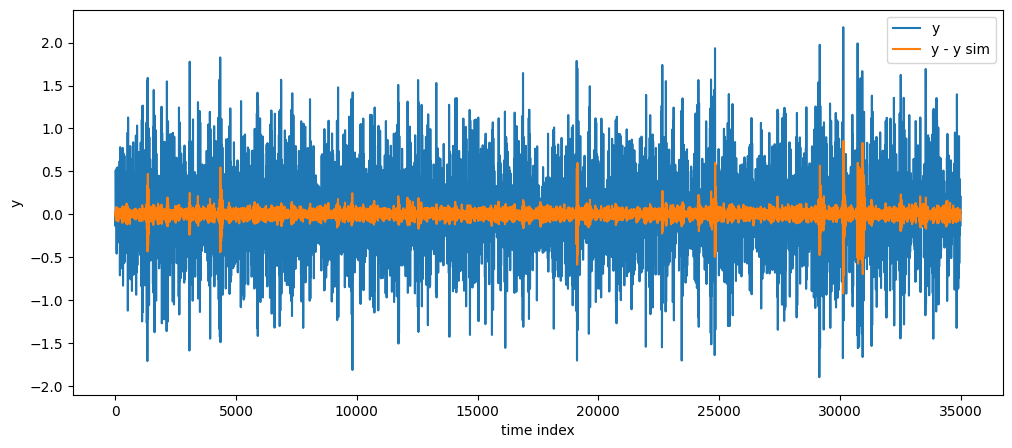

torch.Size([1, 4950])
torch.Size([1, 20])
test simulation errors:
RMS: 0.06716465783533598 radians
RMS: 3.8482514264050276 degrees
NRMS: 14.011981751247172 %


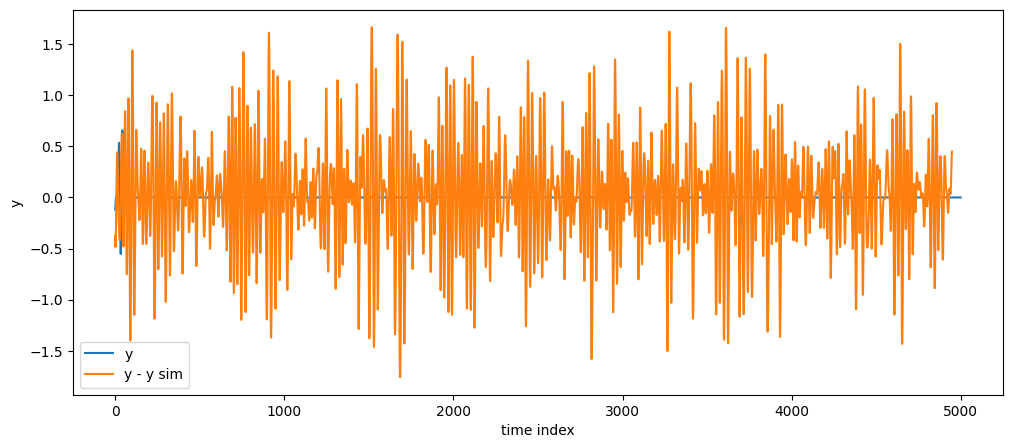

In [59]:
# Set up simulation for identified net
#### What's done with the na and nb here???
# Simulation Test
out = np.load('/content/training-val-test-data.npz')
th_train = out['th'] #th[0],th[1],th[2],th[3],...
u_train = out['u'] #u[0],u[1],u[2],u[3],...

data = np.load('/content/hidden-test-simulation-submission-file.npz')
u_test = data['u']
th_test = data['th'] #only the first 50 values are filled the rest are zeros


def simulation_IO_model(f, ulist, ylist, skip=50):
    upast = ulist[skip-n_encode:skip].tolist() #good initialization
    ypast = ylist[skip-n_encode:skip].tolist()
    hist = np.concatenate([(upast-u_mean)/u_std,(ypast-y_mean)/y_std],axis=0)
    inputs = (np.array(ulist[skip:].tolist()) - u_mean)/u_std
    hist, inputs = convert([hist[None,:], inputs[None,:]])
    ypred = f(inputs,hist).cpu().detach().numpy() * y_std + y_mean
    Y = np.concat([ylist[:skip],ypred])
    return np.array(Y)

skip = n_encode
model.eval()
th_train_sim = simulation_IO_model(lambda x, hist: model.forward(inputs=x,hist=hist)[0], u_train, th_train, skip=skip)
print('trained simulation errors:')
print('RMS:', np.mean((th_train_sim[skip:]-th_train[skip:])**2)**0.5,'radians')
print('RMS:', np.mean((th_train_sim[skip:]-th_train[skip:])**2)**0.5/(2*np.pi)*360,'degrees')
print('NRMS:', np.mean((th_train_sim[skip:]-th_train[skip:])**2)**0.5/th_train.std()*100,'%')
# Plotting
res = th_train_sim[skip:] - th_train[skip:] #b)
plt.figure(figsize=(12,5)) #b)
plt.plot(th_train) #b)
plt.plot(res) #b)
plt.xlabel('time index'); plt.ylabel('y'); plt.legend(['y','y - y sim'])#b)
plt.show() #b)

skip = 50
th_test_sim = simulation_IO_model(lambda x,hist: model(x,hist)[0], u_test, th_test, skip=skip)
print('test simulation errors:')
print('RMS:', np.mean((th_train_sim[skip:]-th_train[skip:])**2)**0.5,'radians')
print('RMS:', np.mean((th_train_sim[skip:]-th_train[skip:])**2)**0.5/(2*np.pi)*360,'degrees')
print('NRMS:', np.mean((th_train_sim[skip:]-th_train[skip:])**2)**0.5/th_train.std()*100,'%')
# Plotting
res = th_test_sim[skip:] - th_test[skip:] #b)
plt.figure(figsize=(12,5)) #b)
plt.plot(th_test) #b)
plt.plot(res) #b)
plt.xlabel('time index'); plt.ylabel('y'); plt.legend(['y','y - y sim'])#b)
plt.show() #b)